In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Show Code"></form>''')

# **Model Building**

At this point data consists of no apparent outlier and missing values. Qualitative features have been encoded appropriately. All features are in numerical format. Dataset is ready to train machine learning models.

In this notebook I train multiple machine learning models, fine-tune them and evaluate their performance using cross-validation. Root-Mean-Squared-Error (RMSE) between the logarithm of predicted and observed sale price is used as the evaluation metric for each validation set. Using logarithm of the sale price as the target variables ensures that the errors in predicting expensive and cheap houses will affect the results equally.

# Table of Contents
1. [Data Splitting](#1.-Data-Splitting)
2. [Feature Standardization](#Feature-Standardization)
3. [Models](#3.-Models)  
    3.1. [Linear Regression](#3.1.-Linear-Regression)  
    3.2. [Ridge Regression](#3.2.-Ridge-Regression)  
    3.3. [Lasso Regression](#3.3.-Lasso-Regression)  
    3.4. [Elastic Net Regression](#3.4.-Elastic-Net-Regression)  
    3.5. [Support Vector Machine Regression](#3.5.-Support-Vector-Machine-Regression)  
    3.6. [Random Forest](#3.6.-Random-Forest)    
    3.7. [Adaptive Boost](#3.7.-Adaptive-Boost)    
    3.8. [Gradient Boost](#3.8.-Gradient-Boost)    
4. [Model Performance](#4.-Model-Performance)

In [2]:
# Import useful libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Import collection library
from collections import defaultdict

# Import visualization libraries
import matplotlib as mpl
import seaborn as sns
sns.set(style ='white',font_scale=1.25)
%matplotlib inline

# Set waring to 'ignore' to prevent them from prining on screen
import warnings
warnings.filterwarnings('ignore')

In [3]:
'''Import the processed dataset'''
with open('data/processed_data.pkl','rb') as file:
    train,y,test,FEATURES = pickle.load(file)
    
for feat in ['ExterQual','KitchenQual']:
    train[feat] = train[feat].astype(np.float)
    test[feat] = test[feat].astype(np.float)

## 1. Data Splitting

Data is split in 70% training and 30% test sets

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=42)

print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1017, 437)
X_test : (437, 437)
y_train : (1017,)
y_test : (437,)


## 2. Feature Standardization

Standardize all features except those that are one hot encoded.

In [5]:
FEATURES.keys()

dict_keys(['cat', 'num', 'aug_num', 'eng_num', 'ord_num', 'onehot_cat', 'interactions', 'interactions_num'])

In [6]:
feat_to_norm = FEATURES['num'] + FEATURES['aug_num'] + FEATURES['eng_num'] + FEATURES['ord_num'] + FEATURES['interactions_num']
print('Total %i features to normalize' %(len(feat_to_norm)))

Total 217 features to normalize


In [7]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(X_train[feat_to_norm])

X_num_train_norm = pd.DataFrame(ss.transform(X_train[feat_to_norm]),columns=feat_to_norm,index=X_train.index)
X_cat_train = X_train[[col for col in X_train.columns if col not in feat_to_norm]]
X_train_preproc = pd.concat([X_num_train_norm,X_cat_train],axis=1)

X_num_test_norm = pd.DataFrame(ss.transform(X_test[feat_to_norm]),columns=feat_to_norm,index=X_test.index)
X_cat_test = X_test[[col for col in X_test.columns if col not in feat_to_norm]]
X_test_preproc = pd.concat([X_num_test_norm,X_cat_test],axis=1)

print("X_train_preproc : " + str(X_train_preproc.shape))
print("X_test_preproc : " + str(X_test_preproc.shape))

X_train_preproc : (1017, 437)
X_test_preproc : (437, 437)


In [8]:
'''Initialize a named tuple that will store cross-validation mean and std of the model performance metric (RSME)'''

from collections import namedtuple

models = namedtuple('models',['name','params',
                              'cv5_mean_train_rmse','cv5_std_train_rmse',
                              'cv5_mean_test_rmse','cv5_std_test_rmse'])
model_list = []

## 3. Models

### 3.1. Linear Regression

In [9]:
# Import linear regression model
from sklearn.linear_model import LinearRegression

# Import mean_squared_error and r2_score libraries
from sklearn.metrics import mean_squared_error, r2_score

# import cross validation score library
from sklearn.model_selection import cross_val_score

In [10]:
def cv_rmse(mod,X,y,cv=5):
    scores = cross_val_score(mod,X,y,scoring="neg_mean_squared_error",cv=cv)
    return np.sqrt(-scores)

In [11]:
lr = LinearRegression()
lr.fit(X_train_preproc,y_train)


y_train_pred = lr.predict(X_train_preproc)
y_test_pred = lr.predict(X_test_preproc)

print('Train R-sq:',r2_score(y_train,y_train_pred))
print('Test R-sq:',r2_score(y_test,y_test_pred))

Train R-sq: 0.963162885762564
Test R-sq: 0.5559804776569269


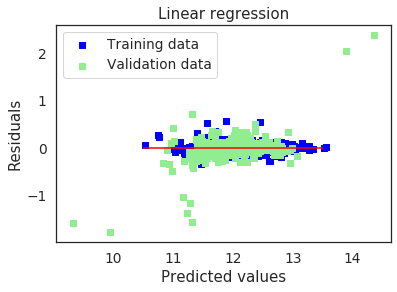

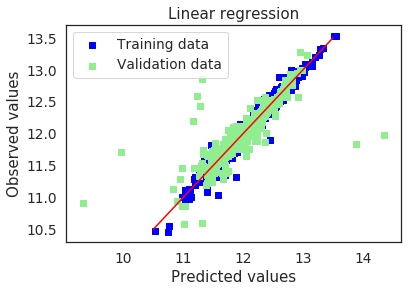

In [12]:
# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Observed values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")

In [13]:
cv5_train_rmse =  cv_rmse(lr, X_train_preproc, y_train, cv=5)
cv5_test_rmse =  cv_rmse(lr, X_test_preproc, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='LR',params=lr.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.88424246 0.21429221 3.33544394 4.79528007 0.20554063]
---------------------------------------------------------------------------
cv5 test rmse: [18.0781871  56.25612769 30.25145329 57.26939607  3.02558067]


### 3.2. Ridge Regression

In [14]:
from sklearn.linear_model import RidgeCV, Ridge

ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train_preproc, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

Best alpha : 30.0


In [15]:
ridge = Ridge(alpha=30)
ridge.fit(X_train_preproc, y_train)
y_pred = ridge.predict(X_test_preproc)

print('Test accuracies:')
print('-'*50)
print('R-sq:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq orig price:', r2_score(y_test_exp, y_pred_exp))
print('MSE orig price:', mean_squared_error(y_test_exp, y_pred_exp))
print('RMSE orig price:', np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))

Test accuracies:
--------------------------------------------------
R-sq: 0.9105856887102585
MSE: 0.013466370334233983
RMSE: 0.11604469110749523
--------------------------------------------------
R-sq orig price: 0.9093166915929819
MSE orig price: 482826655.43037325
RMSE orig price: 21973.316896417193


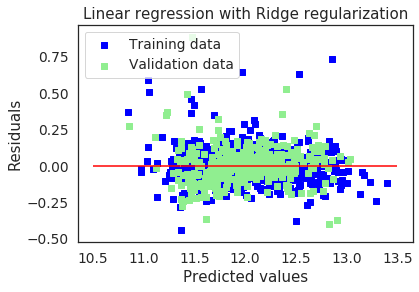

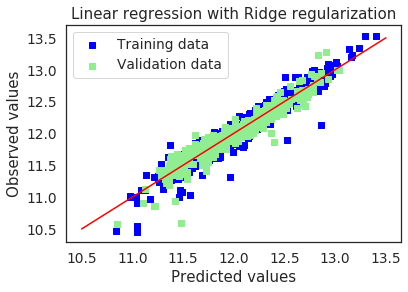

Ridge picked 425 features and eliminated the other 12 features


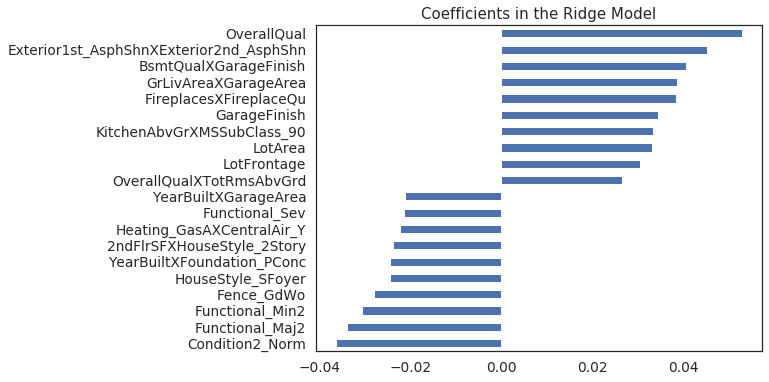

In [16]:
y_train_rdg = ridge.predict(X_train_preproc)
y_test_rdg = ridge.predict(X_test_preproc)

# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Observed values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the Ridge Model");

In [17]:
cv5_train_rmse =  cv_rmse(ridge, X_train_preproc, y_train, cv=5)
cv5_test_rmse =  cv_rmse(ridge, X_test_preproc, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='ridge',params=ridge.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.13960656 0.1517983  0.11474914 0.12234125 0.10451124]
---------------------------------------------------------------------------
cv5 test rmse: [0.12105209 0.12569209 0.14701506 0.10640766 0.10088073]


### 3.3. Lasso Regression

In [18]:
from sklearn.linear_model import LassoCV, Lasso

In [21]:
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train_preproc, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

Best alpha : 0.0003


In [19]:
lasso = Lasso(alpha=0.0003)
lasso.fit(X_train_preproc, y_train)
y_pred = lasso.predict(X_test_preproc)
print('R-sq:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))


y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq orig price:', r2_score(y_test_exp, y_pred_exp))
print('MSE orig price:', mean_squared_error(y_test_exp, y_pred_exp))
print('RMSE orig price:', np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))

R-sq: 0.9031192608306124
MSE: 0.01459086239205849
RMSE: 0.12079264212715313
--------------------------------------------------
R-sq orig price: 0.8970553091861273
MSE orig price: 548110138.8238426
RMSE orig price: 23411.752151939476


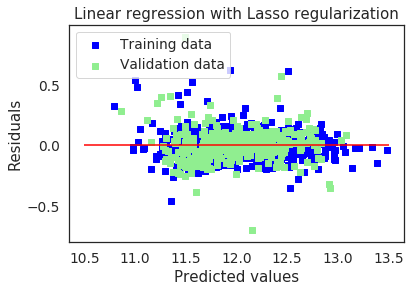

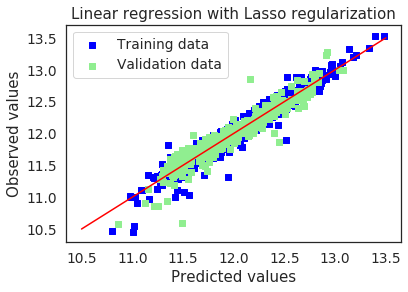

Lasso picked 167 features and eliminated the other 270 features


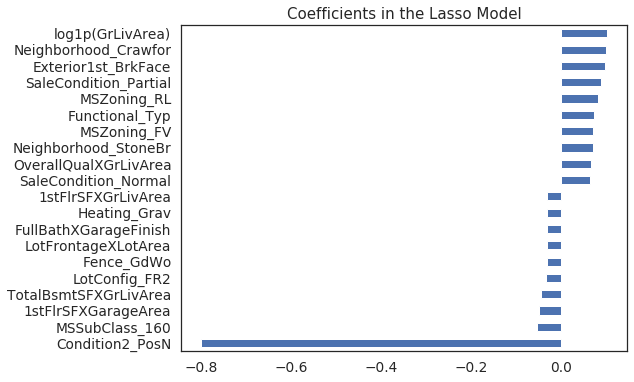

In [20]:
y_train_las = lasso.predict(X_train_preproc)
y_test_las = lasso.predict(X_test_preproc)

# Plot residuals
plt.scatter(y_train_las, y_train_las - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Observed values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train_preproc.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the Lasso Model");

In [21]:
cv5_train_rmse =  cv_rmse(lasso, X_train_preproc, y_train, cv=5)
cv5_test_rmse =  cv_rmse(lasso, X_test_preproc, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='lasso',params=lasso.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.1417541  0.1485384  0.11527221 0.11838428 0.10338615]
---------------------------------------------------------------------------
cv5 test rmse: [0.12658824 0.13605281 0.15164647 0.107525   0.10042819]


### 3.4. Elastic Net Regression

In [22]:
from sklearn.linear_model import ElasticNetCV, ElasticNet

In [24]:
enet = ElasticNetCV(l1_ratio=np.arange(0,1.1,0.1),
             alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1],
             cv=5,
             max_iter=50000,
             n_jobs=16,
             random_state=42)
enet.fit(X_train_preproc, y_train)

ElasticNetCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03,
                     0.06, 0.1, 0.3, 0.6, 1],
             copy_X=True, cv=5, eps=0.001, fit_intercept=True,
             l1_ratio=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
             max_iter=50000, n_alphas=100, n_jobs=16, normalize=False,
             positive=False, precompute='auto', random_state=42,
             selection='cyclic', tol=0.0001, verbose=0)

In [26]:
print('Best alpha: ',enet.alpha_)
print('Best l1_ratio: ',enet.l1_ratio_)

Best alpha:  0.0003
Best l1_ratio:  1.0


In [23]:
enet = ElasticNet(l1_ratio=1,alpha=0.0003) 
enet.fit(X_train_preproc,y_train)
y_pred = enet.predict(X_test_preproc)

print('R-sq:', r2_score(y_test,y_pred))
print('MSE:', mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))

y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:', r2_score(y_test_exp,y_pred_exp))
print('MSE:', mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:', np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.9031192608306124
MSE: 0.01459086239205849
RMSE: 0.12079264212715313
--------------------------------------------------
R-sq: 0.8970553091861273
MSE: 548110138.8238426
RMSE: 23411.752151939476


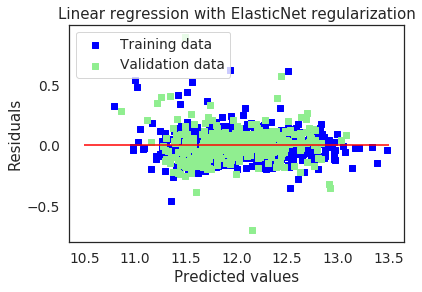

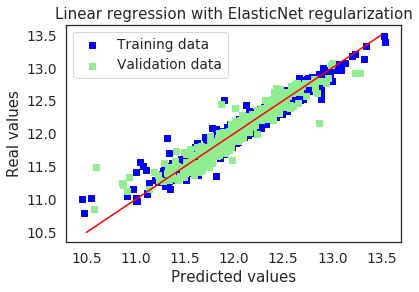

ElasticNet picked 167 features and eliminated the other 270 features


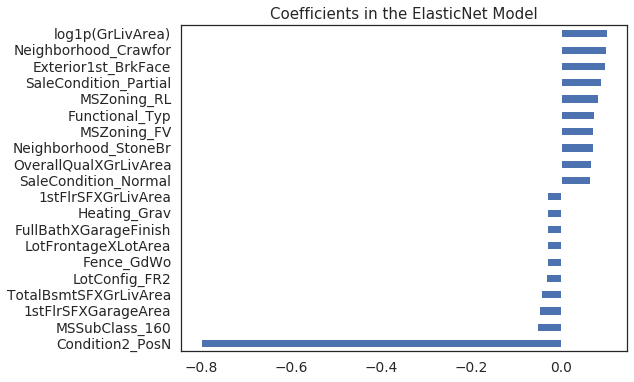

In [24]:
y_train_ela = enet.predict(X_train_preproc)
y_test_ela = enet.predict(X_test_preproc)

# Plot residuals
plt.scatter(y_train_ela, y_train_ela - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ela, y_test_ela - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train, y_train_ela, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test, y_test_ela, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(enet.coef_, index = X_train_preproc.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the ElasticNet Model");

In [25]:
cv5_train_rmse =  cv_rmse(enet, X_train_preproc, y_train, cv=5)
cv5_test_rmse =  cv_rmse(enet, X_test_preproc, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='enet',params=enet.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.1417541  0.1485384  0.11527221 0.11838428 0.10338615]
---------------------------------------------------------------------------
cv5 test rmse: [0.12658824 0.13605281 0.15164647 0.107525   0.10042819]


### 3.5. Support Vector Machine Regression

In [26]:
from sklearn.svm import SVR

In [27]:
svm = SVR(C=0.1, cache_size=200, coef0=1, degree=3, epsilon=0.1,
          gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
          tol=0.001, verbose=False)
svm.fit(X_train_preproc,y_train)
y_pred = svm.predict(X_test_preproc)

print('R-sq:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))

y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:',r2_score(y_test_exp,y_pred_exp))
print('MSE:',mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:',np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.8972963149569132
MSE: 0.01546783548999288
RMSE: 0.12436975311542948
--------------------------------------------------
R-sq: 0.906451027188323
MSE: 498084360.34203297
RMSE: 22317.8036630407


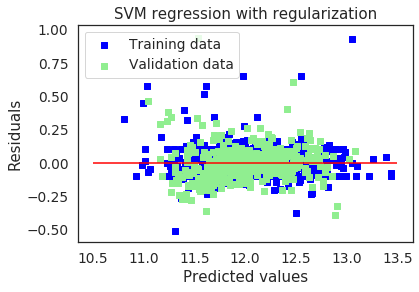

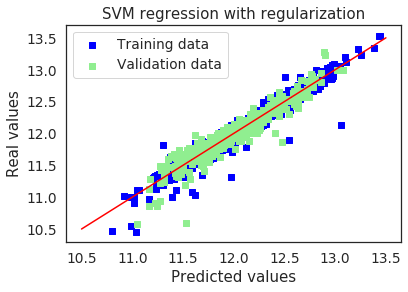

SVR picked up 409 features and eliminated 28 features


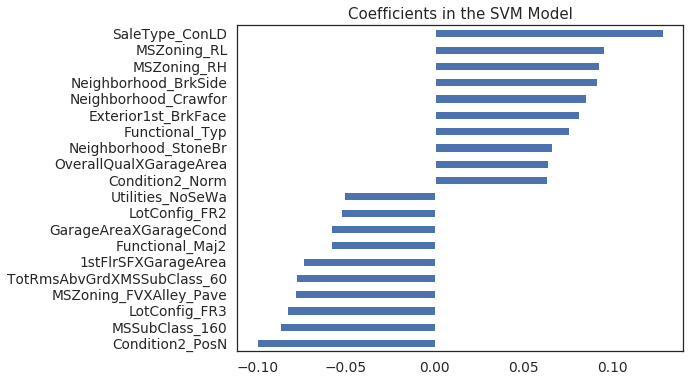

In [28]:
y_train_svm = svm.predict(X_train_preproc)
y_test_svm = svm.predict(X_test_preproc)

# Plot residuals
plt.scatter(y_train_svm, y_train_svm - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_svm, y_test_svm - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("SVM regression with regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_svm, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_svm, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("SVM regression with regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(np.squeeze(svm.coef_) , index = X_train_preproc.columns)
print("SVR picked up " + str(sum(coefs != 0)) + " features and eliminated " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the SVM Model");

In [29]:
cv5_train_rmse =  cv_rmse(svm, X_train_preproc, y_train, cv=5)
cv5_test_rmse =  cv_rmse(svm, X_test_preproc, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='svm',params=svm.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.15201877 0.15794401 0.12864226 0.13164219 0.13401852]
---------------------------------------------------------------------------
cv5 test rmse: [0.13685693 0.14364448 0.14992418 0.12440565 0.11855427]


### 3.6. Random Forest

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [ ]:
param_dist = dict(n_estimators=[200,500,700,900,1200],max_features=["auto","sqrt",'log2'])
rf_cv = RandomizedSearchCV(RandomForestRegressor(),
                           param_distributions=param_dist,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           n_iter=10)
rf_cv.fit(X_train,y_train)
print(rf_cv.best_estimator_)

In [32]:
rf = RandomForestRegressor(max_features='log2', n_estimators=700)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print('R-sq:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))

y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:',r2_score(y_test_exp,y_pred_exp))
print('MSE:',mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:',np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.8861814673445716
MSE: 0.017141803023795726
RMSE: 0.1309267085960528
--------------------------------------------------
R-sq: 0.9003613511509798
MSE: 530507724.30409795
RMSE: 23032.75329403973


In [33]:
feature_importance = pd.DataFrame(np.round(rf.feature_importances_,decimals=4),
                                  index=X_train.columns,columns=['importance']).sort_values(by='importance',
                                                                                            ascending=False)
feature_importance.index.name = 'feature'
feature_importance.reset_index(inplace =True)

Text(0.5, 1.0, 'Top 10 Important Features')

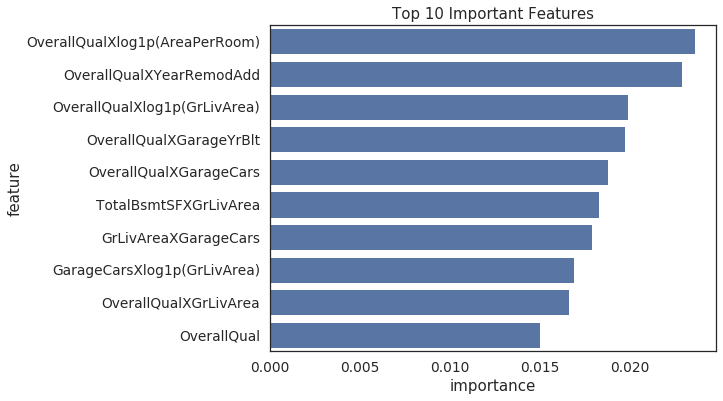

In [34]:
plt.figure(figsize=(8,6))
sns.barplot(y='feature',x='importance',data=feature_importance.sort_values('importance',ascending=False)[:10],orient='h',color='C0')
plt.title('Top 10 Important Features')

In [35]:
cv5_train_rmse =  cv_rmse(rf, X_train, y_train, cv=5)
cv5_test_rmse =  cv_rmse(rf, X_test, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='rf',params=rf.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.1617681  0.14828696 0.14869648 0.15731478 0.11847533]
---------------------------------------------------------------------------
cv5 test rmse: [0.1383979  0.1462592  0.17383233 0.10747935 0.12640776]


### 3.7. Adaptive Boost

In [36]:
from sklearn.ensemble import AdaBoostRegressor

In [37]:
with open('ada_mod.pkl','rb') as mod_file:
    ada_cv = pickle.load(mod_file)
    
ada_cv.best_estimator_

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=25,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=12,
                                                       min_samples_split=15,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=0.5, loss='square', n_estimators=400,
                  rand

In [38]:
ada = ada_cv.best_estimator_
ada.fit(X_train,y_train)

y_pred = ada.predict(X_test)

print('R-sq:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:',r2_score(y_test_exp,y_pred_exp))
print('MSE:',mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:',np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.8950795209921498
MSE: 0.015801698918045958
RMSE: 0.12570480865124437
--------------------------------------------------
R-sq: 0.9150592967072496
MSE: 452251206.9880375
RMSE: 21266.198696241827


Text(0.5, 1.0, 'Top 10 Important Features')

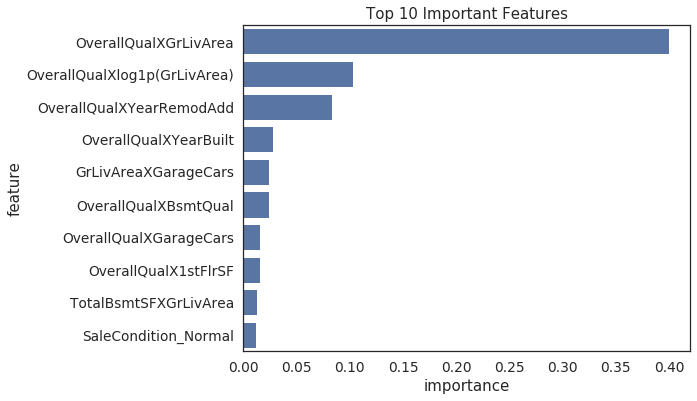

In [39]:
feature_importance = pd.DataFrame(np.round(ada.feature_importances_,decimals=4),
                                  index=X_train.columns,columns=['importance']).sort_values(by='importance',
                                                                                            ascending=False)
feature_importance.index.name = 'feature'
feature_importance.reset_index(inplace = True)

plt.figure(figsize=(8,6))
sns.barplot(y='feature',x='importance',data=feature_importance.sort_values('importance',ascending=False)[:10],orient='h',color='C0')
plt.title('Top 10 Important Features')

In [40]:
cv5_train_rmse =  cv_rmse(ada, X_train, y_train, cv=5)
cv5_test_rmse =  cv_rmse(ada, X_test, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='ada',params=ada.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.15732734 0.15309394 0.14109188 0.14866866 0.1340643 ]
---------------------------------------------------------------------------
cv5 test rmse: [0.13903339 0.15405809 0.17531563 0.09668494 0.12425412]


### 3.8. Gradient Boost

In [41]:
from sklearn.ensemble import GradientBoostingRegressor

In [42]:
gbrt = GradientBoostingRegressor()
gbrt.fit(X_train,y_train)
y_pred = gbrt.predict(X_test)

print('Test accuracies:')
print('-'*50)
print('R-sq:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq orig price:', r2_score(y_test_exp, y_pred_exp))
print('MSE orig price:', mean_squared_error(y_test_exp, y_pred_exp))
print('RMSE orig price:', np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))

Test accuracies:
--------------------------------------------------
R-sq: 0.9047186874019437
MSE: 0.014349978463957016
RMSE: 0.11979139561736901
--------------------------------------------------
R-sq orig price: 0.9025968917918211
MSE orig price: 518604997.88556606
RMSE orig price: 22772.900515427675


Text(0.5, 1.0, 'Top 10 Important Features')

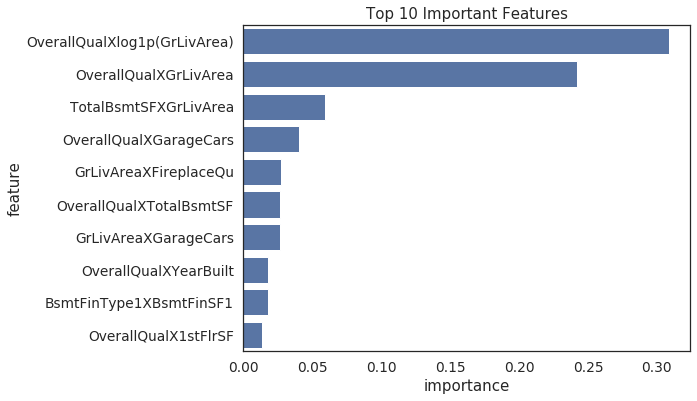

In [43]:
feature_importance = pd.DataFrame(np.round(gbrt.feature_importances_,decimals=4),
                                  index=X_train.columns,columns=['importance']).sort_values(by='importance',
                                                                                            ascending=False)
feature_importance.index.name = 'feature'
feature_importance.reset_index(inplace = True)

plt.figure(figsize=(8,6))
sns.barplot(y='feature',x='importance',data=feature_importance.sort_values('importance',ascending=False)[:10],orient='h',color='C0')
plt.title('Top 10 Important Features')

In [44]:
cv5_train_rmse =  cv_rmse(gbrt, X_train, y_train, cv=5)
cv5_test_rmse =  cv_rmse(gbrt, X_test, y_test, cv=5)

print('cv5 train rmse:',cv5_train_rmse)
print('-'*75)
print('cv5 test rmse:', cv5_test_rmse)

model_list.append(models(name='gbrt',params=gbrt.get_params(),
                         cv5_mean_train_rmse = np.mean(cv5_train_rmse),
                         cv5_std_train_rmse=np.std(cv5_train_rmse),
                         cv5_mean_test_rmse=np.mean(cv5_test_rmse),
                         cv5_std_test_rmse=np.std(cv5_test_rmse)))

cv5 train rmse: [0.15387309 0.14543828 0.13756873 0.14312645 0.11789989]
---------------------------------------------------------------------------
cv5 test rmse: [0.13098737 0.15374636 0.16624494 0.10074862 0.11837242]


## 4. Model Performance

In [45]:
mod_table = pd.DataFrame()
for model in model_list:
    tmp_df = pd.DataFrame([model.name,
                           model.cv5_mean_train_rmse,
                           model.cv5_std_train_rmse,
                           model.cv5_mean_test_rmse,
                           model.cv5_std_test_rmse],
                          index=['model',
                                   'train_mean_rmse',
                                   'train_std_rmse',
                                   'test_mean_rmse',
                                   'test_std_rmse']).T
    
    mod_table = pd.concat([mod_table,tmp_df],axis=0)
    
mod_table.reset_index(drop=True,inplace=True)

In [46]:
for col in mod_table.columns:
    if col != 'model':
        mod_table[col]= mod_table[col].astype(float)

In [47]:
mod_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 5 columns):
model              8 non-null object
train_mean_rmse    8 non-null float64
train_std_rmse     8 non-null float64
test_mean_rmse     8 non-null float64
test_std_rmse      8 non-null float64
dtypes: float64(4), object(1)
memory usage: 400.0+ bytes


Text(0.5, 1.0, 'Train vs. Validation RMSE')

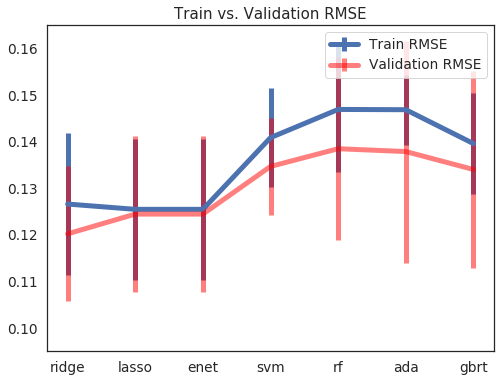

In [48]:
train_errorbar_width_array = (mod_table.loc[1:,'train_std_rmse']/np.sqrt(5))*2

plt.figure(figsize =(8,6))
plt.errorbar(x=mod_table.loc[1:,'model'],
             y=mod_table.loc[1:,'train_mean_rmse'],
             yerr=train_errorbar_width_array,
             label='Train RMSE',
             linewidth=5)

test_errorbar_width_array = (mod_table.loc[1:,'test_std_rmse']/np.sqrt(5))*2
plt.errorbar(x=mod_table.loc[1:,'model'],
             y=mod_table.loc[1:,'test_mean_rmse'],
             yerr=test_errorbar_width_array,
             label='Validation RMSE',
             linewidth=5,
             color='red',
             alpha =0.5)
plt.legend()
plt.ylim(0.095,0.165)
plt.title('Train vs. Validation RMSE')

In [50]:
mod_table.rename(columns={'test_mean_rmse':'val_mean_rmse','test_std_rmse':'val_std_rmse'},inplace=True)

In [51]:
mod_table.sort_values(by=['val_mean_rmse','val_std_rmse'],ascending=[True,True])

,model,train_mean_rmse,train_std_rmse,val_mean_rmse,val_std_rmse
1,ridge,0.126601,0.017033,0.120210,0.016207
2,lasso,0.125467,0.016966,0.124448,0.018667
3,enet,0.125467,0.016966,0.124448,0.018667
7,gbrt,0.139581,0.012044,0.134020,0.023616
4,svm,0.140853,0.011810,0.134677,0.011688
6,ada,0.146849,0.008351,0.137869,0.026635
5,rf,0.146908,0.015117,0.138475,0.021987
0,LR,1.886960,1.854015,32.976149,21.253372
